# Longitudinal Clustering (clustering transactions over time)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read in the dataset
trans_df = pd.read_csv(os.path.join("..", "data", "Final transactions for analysis.csv"))

In [2]:
trans_df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre', 'Month Name', 'Weekday Name', 'YearMonth'],
      dtype='object')

In [57]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

# Convert 'Transaction Date' to datetime
trans_df['Transaction Date'] = pd.to_datetime(trans_df['Transaction Date'])

# Aggregate data monthly per vehicle for 'No. of Litres' and 'Transaction Amount'
monthly_data = trans_df.groupby(['REG_NUM', trans_df['Transaction Date'].dt.to_period("M")]).agg({
    'No. of Litres': 'sum',
    'Transaction Amount': 'sum',
    'Estimated Price Per Litre': 'mean',
}).reset_index()

# Pivot the table to get a wide-format DataFrame where each row represents a vehicle and columns represent monthly aggregated values
pivot_data = monthly_data.pivot(index='REG_NUM', columns='Transaction Date', values=['No. of Litres', 'Transaction Amount']).fillna(0)

# Flatten the MultiIndex columns and create a simple columnar structure for easy reference
pivot_data.columns = ['_'.join(map(str, col)).strip() for col in pivot_data.columns.values]

# Reset index to bring 'REG_NUM' back as a column
pivot_data.reset_index(inplace=True)

pivot_data.head()

,REG_NUM,No. of Litres_2021-04,No. of Litres_2021-05,No. of Litres_2021-06,No. of Litres_2021-07,No. of Litres_2021-08,No. of Litres_2021-09,No. of Litres_2021-10,No. of Litres_2021-11,No. of Litres_2021-12,...,Transaction Amount_2021-04,Transaction Amount_2021-05,Transaction Amount_2021-06,Transaction Amount_2021-07,Transaction Amount_2021-08,Transaction Amount_2021-09,Transaction Amount_2021-10,Transaction Amount_2021-11,Transaction Amount_2021-12,Transaction Amount_2022-01
0,GGA001EC,729.15,0.0,0.0,69.24,1301.04,724.48,140.12,0.00,0.00,...,12114.26,0.0,0.0,1172.95,22575.03,12552.25,2425.27,0.00,0.00,0.00
1,GGA002EC,926.28,0.0,0.0,35.91,1232.96,434.78,681.23,528.97,379.58,...,15294.64,0.0,0.0,609.40,21520.50,7606.80,12006.87,10056.22,7540.35,0.00
2,GGA005EC,298.22,0.0,0.0,0.00,2249.16,1146.64,1361.24,112.58,0.00,...,4813.30,0.0,0.0,0.00,38762.44,19948.26,23995.00,2151.40,0.00,0.00
3,GGA007EC,0.00,0.0,0.0,0.00,0.00,60.64,0.00,75.20,0.00,...,0.00,0.0,0.0,0.00,0.00,1014.05,0.00,1385.95,0.00,0.00
4,GGA008EC,275.94,0.0,0.0,0.00,395.53,283.20,223.83,502.56,148.60,...,4406.89,0.0,0.0,0.00,6557.82,4677.08,3829.42,9093.62,2814.89,12952.28


## Longitudinal KMeans Clustering

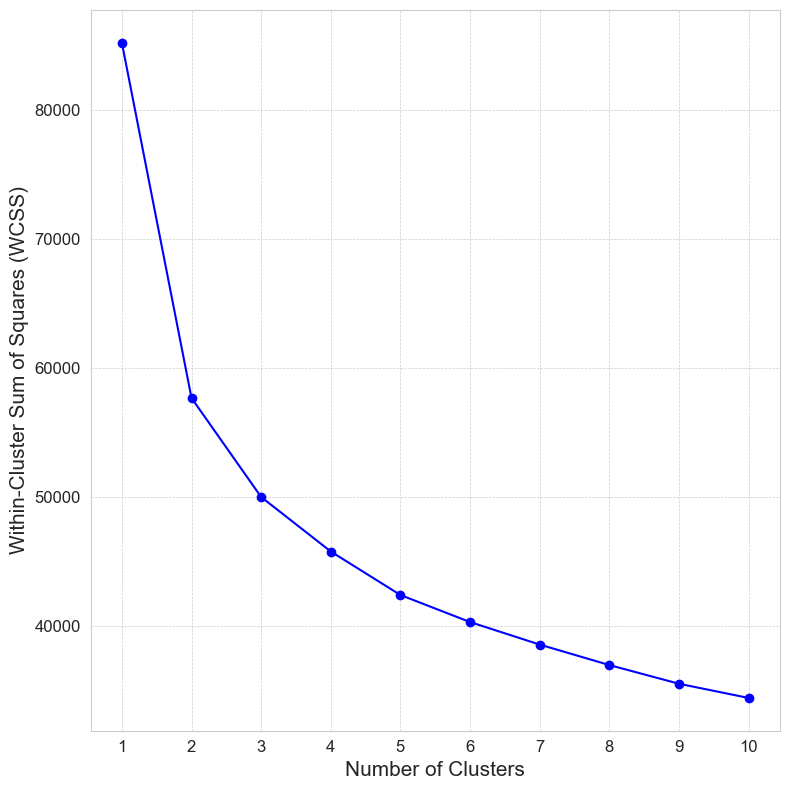

In [58]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering (excluding 'REG_NUM' for actual clustering)
X = pivot_data.iloc[:, 1:].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=15)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/longitudinal_clustering/lkmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [59]:
# Apply KMeans clustering
kclusts = 3
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_scaled)

# Create a dataset with only the REG_NUM and the cluster labels
vehicle_clusters = pivot_data[['REG_NUM']].copy()

# Add cluster labels to the pivot_data DataFrame
vehicle_clusters['LKM Cluster'] = kmeans.labels_

## Longitudinal Agglomerative Clustering

In [61]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute the condensed Euclidean distance matrix
distance_matrix = pdist(X_scaled, metric='euclidean')

# Perform hierarchical clustering using the Ward method
Z = linkage(distance_matrix, metric='ward')

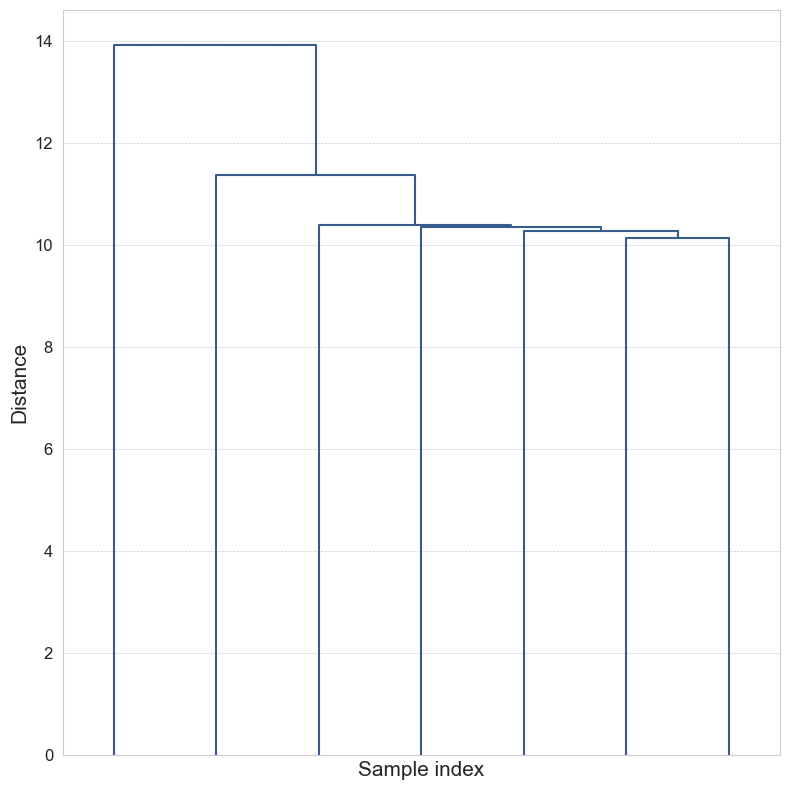

In [62]:
# Plotting the dendrogram
plt.figure(figsize=(8, 8))
dendrogram(Z, no_labels=True, truncate_mode='level', p=5, color_threshold=np.inf) # Labels are omitted for clarity
# plt.title('Agglomerative Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample index', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the dendrogram as a PDF file with high resolution
plt.savefig('../final_plots/longitudinal_clustering/agglomerative_dendrogram.pdf', format='pdf', dpi=300)

plt.show()  # Display the dendrogram

In [63]:
# Perform Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=3, metric='euclidean')
clusters = agg_clust.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
vehicle_clusters['LongAggCluster'] = clusters

In [64]:
# Check the vehicle clusters
vehicle_clusters.head()

,REG_NUM,LKM Cluster,LongAggCluster
0,GGA001EC,0,0
1,GGA002EC,0,1
2,GGA005EC,0,1
3,GGA007EC,1,0
4,GGA008EC,0,0


In [65]:
# Save the longitudinal clusters to a CSV file
vehicle_clusters.to_csv('../data/final_longitudinal_clusters.csv', index=False)

# Aggregated data clustering (clustering vehicles)

In [66]:
# Read in the aggregated dataset
data_agg = pd.read_csv(os.path.join("..", "data", "Final aggregated with KMPL and Imputed.csv"))
vehicle_clusters = pd.read_csv(os.path.join("..", "data", "final_longitudinal_clusters.csv"))

In [33]:
data_agg.columns

Index(['Reg', 'Total Transaction Amount', 'Avg Transaction Amount',
       'Sum of Litres', 'Avg Litres', 'Model', 'Make and Model', 'District',
       'Site', 'Category', 'Site Lat', 'Site Long', 'Fuel Type', 'Rental',
       'Avg Actual Fuel Price', 'Avg Actual Fuel Price Inland',
       'Avg Estimated Price Per Litre', 'Total Kilometres', 'Total Litres',
       'KMPL'],
      dtype='object')

In [67]:
# Select the columns for clustering
columns_for_clustering = ['Reg', 'Total Transaction Amount', 'Sum of Litres', 'Model', 
                          'District', 'Category', 'Site Lat', 'Site Long', 'Fuel Type', 
                          'Avg Estimated Price Per Litre'
                          #'Rental', 'KMPL'
                          ]

data_agg_clustering = data_agg[columns_for_clustering]

# Remove rows with missing values
data_agg_clusters = data_agg_clustering.dropna()

# Select the data without the REG_NUM column for the actual clustering
data_agg_clustering = data_agg_clusters.drop('Reg', axis=1)

# Encode the categorical variables
data_agg_encoded = pd.get_dummies(data_agg_clustering)

# Prepare data for clustering (excluding 'REG_NUM' for actual clustering)
X_agg = data_agg_encoded.values

# Standardize the features
scaler_agg = StandardScaler()
X_agg_scaled = scaler_agg.fit_transform(X_agg)

X_agg_scaled.shape

(1635, 59)

## KMeans Clustering

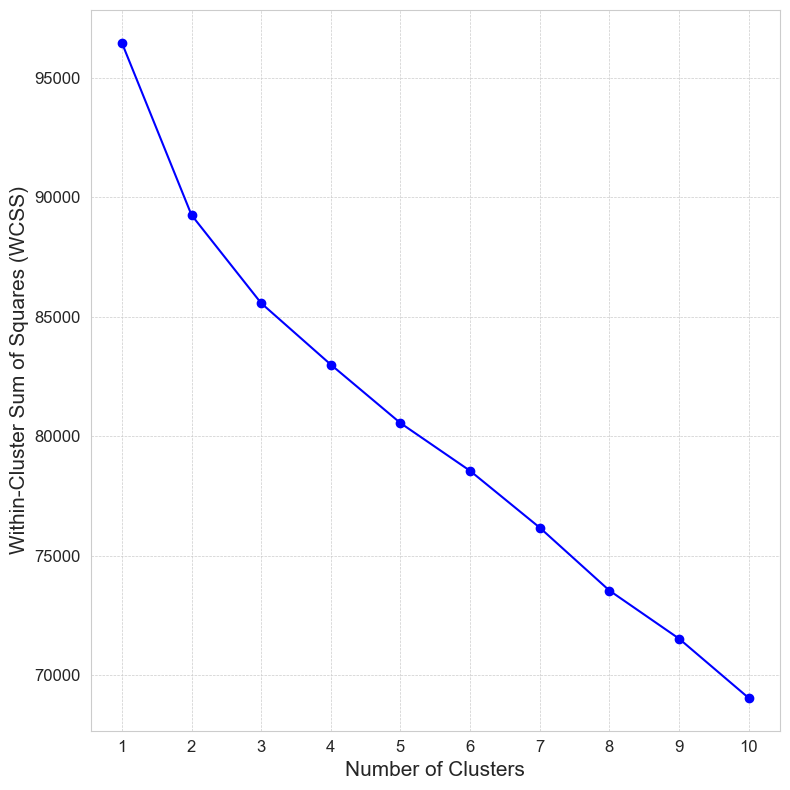

In [229]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_agg_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=15)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/aggregated_clustering/kmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [68]:
# Apply KMeans clustering
kclusts = 3
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_agg_scaled)

# Add cluster labels to the pivot_data DataFrame
data_agg_clusters['AggKmeansCluster'] = kmeans.labels_

## Agglomerative Clustering

In [69]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Compute the condensed Euclidean distance matrix
distance_matrix = pdist(X_agg_scaled, metric='euclidean')

# Perform hierarchical clustering using the Ward method
Z_agg = linkage(distance_matrix, metric='ward')

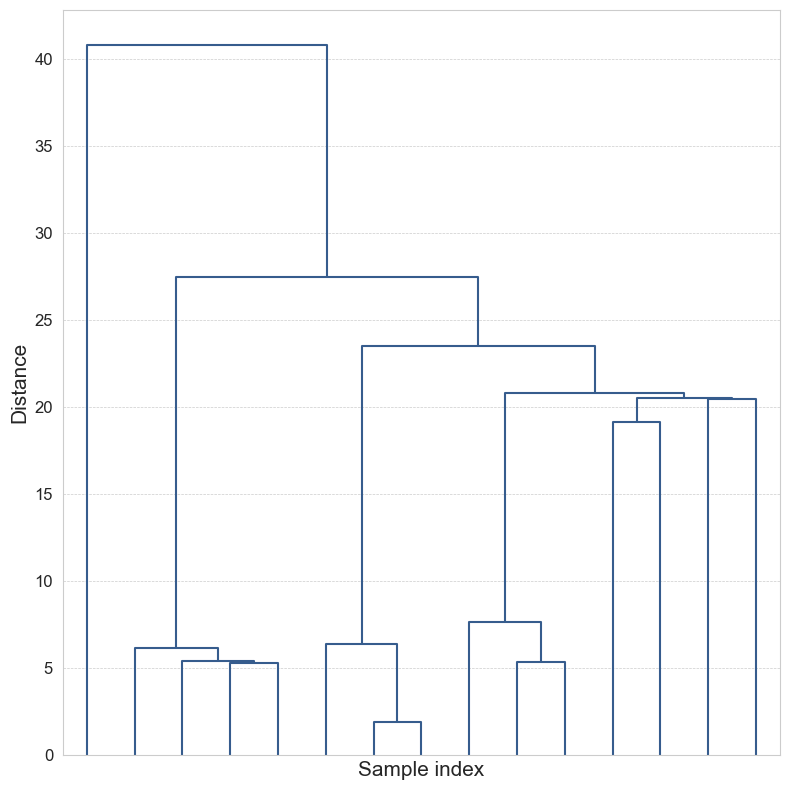

In [39]:
# Plotting the dendrogram
plt.figure(figsize=(8, 8))
dendrogram(Z_agg, no_labels=True, truncate_mode='level', p=5, color_threshold=np.Inf) # Labels are omitted for clarity
# plt.title('Agglomerative Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Sample index', fontsize=15)
plt.ylabel('Distance', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the dendrogram as a PDF file with high resolution
plt.savefig('../final_plots/aggregated_clustering/agglomerative_dendrogram.pdf', format='pdf', dpi=300)

plt.show()  # Display the dendrogram

In [70]:
# Perform Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=3, metric='euclidean')
clusters = agg_clust.fit_predict(X_agg_scaled)

# Add cluster labels to the DataFrame
data_agg_clusters['AggregatedAggCluster'] = clusters

# Plotting the longitudinal and aggregated clusters

In [43]:
data_agg_clusters.head()

,Reg,Total Transaction Amount,Sum of Litres,Model,District,Category,Site Lat,Site Long,Fuel Type,Avg Estimated Price Per Litre,AggKmeansCluster,AggregatedAggCluster
0,GGA001EC,50839.76,2964.03,RANGER,OR Tambo,CATEGORY 18: Ambulances Large p/van,-31.594050,28.756873,DIESEL,17.148712,2,2
2,GGA005EC,89670.40,5167.84,RANGER,OR Tambo,CATEGORY 8: LDV Ambulance,-31.319447,28.754782,DIESEL,17.338017,2,2
4,GGA008EC,44332.00,2526.30,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.554233,2,2
5,GGA011EC,38048.05,2159.65,RANGER,Nelson Mandela,CATEGORY 8: LDV Ambulance,-33.745241,25.568108,DIESEL,17.614812,2,0
7,GGA013EC,27334.79,1575.63,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.355279,2,2


In [49]:
vehicle_clusters.head()

,REG_NUM,LKM Cluster,LongAggCluster
0,GGA001EC,0,1
1,GGA002EC,0,1
2,GGA005EC,0,1
3,GGA007EC,1,1
4,GGA008EC,0,1


In [71]:
# Rename the 'Reg' column to 'REG_NUM' to match the vehicle clusters
data_agg_clusters.rename(columns={'Reg': 'REG_NUM'}, inplace=True)

# Add the longitidunal clusters to the aggregated dataset based on the 'REG_NUM'
data_vehicles = data_agg_clusters.merge(vehicle_clusters, on='REG_NUM')

data_vehicles.head()

,REG_NUM,Total Transaction Amount,Sum of Litres,Model,District,Category,Site Lat,Site Long,Fuel Type,Avg Estimated Price Per Litre,AggKmeansCluster,AggregatedAggCluster,LKM Cluster,LongAggCluster
0,GGA001EC,50839.76,2964.03,RANGER,OR Tambo,CATEGORY 18: Ambulances Large p/van,-31.594050,28.756873,DIESEL,17.148712,2,2,0,0
1,GGA005EC,89670.40,5167.84,RANGER,OR Tambo,CATEGORY 8: LDV Ambulance,-31.319447,28.754782,DIESEL,17.338017,2,2,0,1
2,GGA008EC,44332.00,2526.30,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.554233,2,2,0,0
3,GGA011EC,38048.05,2159.65,RANGER,Nelson Mandela,CATEGORY 8: LDV Ambulance,-33.745241,25.568108,DIESEL,17.614812,2,0,1,0
4,GGA013EC,27334.79,1575.63,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.355279,2,2,1,1


In [72]:
data_vehicles.to_csv('../data/final_clusters.csv', index=False)

In [87]:
# Read in the dataset
data_vehicles = pd.read_csv('../data/final_clusters.csv')

In [236]:
data_vehicles.columns

Index(['REG_NUM', 'Total Transaction Amount', 'Sum of Litres', 'Model',
       'District', 'Category', 'Site Lat', 'Site Long', 'Fuel Type',
       'Avg Estimated Price Per Litre', 'AggKmeansCluster',
       'AggregatedAggCluster', 'LKM Cluster', 'LongAggCluster'],
      dtype='object')

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_categories(data, cluster_column, categorical_var, num_top_categories, legend_title, output_path='../plots/time_clustering'):
    """
    Generates and saves a dynamic subplot grid showing the top categories for each cluster.
    """
    # Determine the top categories in each cluster
    top_categories = data.groupby([cluster_column, categorical_var]) \
                         .size() \
                         .reset_index(name='Counts') \
                         .sort_values(by=[cluster_column, 'Counts'], ascending=[True, False]) \
                         .groupby(cluster_column) \
                         .head(num_top_categories)

    # Number of clusters
    num_clusters = data[cluster_column].nunique()

    # Determine subplot grid dimensions
    if num_clusters <= 4:
        nrows, ncols = 2, 2
    else:  # For 5 or 6 clusters
        nrows, ncols = 3, 2

    plt.figure(figsize=(12, 7))  # Adjust figure size as needed

    # Sort the unique cluster labels to ensure proper order
    sorted_clusters = sorted(data[cluster_column].unique())

    # Create a subplot for each cluster
    for i, cluster in enumerate(sorted_clusters):
        plt.subplot(nrows, ncols, i + 1)
        cluster_data = top_categories[top_categories[cluster_column] == cluster]

        # Check if the cluster has data
        if not cluster_data.empty:
            sns.barplot(x=cluster_column, y='Counts', hue=categorical_var, data=cluster_data, palette="viridis")
            plt.xlabel('Cluster', fontsize=13)
            plt.ylabel('Count', fontsize=13)
            plt.title(f'Cluster {cluster}')
            plt.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1))
        else:
            plt.text(0.5, 0.5, f'No data for Cluster {cluster}', fontsize=13, ha='center')

    plt.tight_layout()
    plt.savefig(f'{output_path}/top_{cluster_column}_{categorical_var}.pdf', format='pdf', dpi=300)

# Function to truncate category names
def truncate_category_names(categories, max_length=15):
    """Truncate category names to a maximum length, appending '...' if longer."""
    truncated = [(cat[:max_length] + '...') if len(cat) > max_length else cat for cat in categories]
    return truncated

def plot_bivariate_grid(df, numeric_var, cat_vars, plot_file_path):
    """
    Plots a 2x2 grid of box plots for a numeric variable against top 10 categories of 4 categorical variables.

    Parameters:
    - df: DataFrame containing the data.
    - numeric_var: The numeric variable for y-axis.
    - cat_vars: A list of 4 categorical variables for x-axis.
    - plot_file_path: Path to save the plot PDF file.
    """
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    plt.rc('axes', titlesize=16)  # Set the font size for plot titles
    plt.rc('axes', labelsize=15)  # Set the font size for axis labels (x and y)
    plt.rc('xtick', labelsize=12)  # Set the font size for x-axis tick labels
    plt.rc('ytick', labelsize=12)  # Set the font size for y-axis tick labels
    sns.set_palette('viridis')

    if len(cat_vars) == 4:
        # Prepare the figure for the grid of plots
        fig, axs = plt.subplots(2, 2, figsize=(10, 10), dpi=150)
        plot_prefix = ['a)', 'b)', 'c)', 'd)']

        for i, variable in enumerate(cat_vars):
            # Find the top 10 categories for the current variable
            top_categories = df[variable].value_counts().nlargest(10).index
            truncated_categories = truncate_category_names(top_categories, max_length=17)
            category_mapping = dict(zip(top_categories, truncated_categories))
            filtered_df = df.loc[df[variable].isin(top_categories)].copy()
            filtered_df[variable] = filtered_df[variable].map(category_mapping)
            
            ax = axs[i // 2, i % 2]
            sns.boxplot(x=variable, y=numeric_var, data=filtered_df, ax=ax, order=truncated_categories)
            ax.set_title(f'{plot_prefix[i]} {variable} vs {numeric_var}', fontsize=16)
            ax.set_xlabel(variable, fontsize=15)
            ax.set_ylabel(numeric_var, fontsize=15)
            ax.tick_params(axis='x', labelrotation=45)
    else:
        # Prepare the figure for the grid of plots
        fig, axs = plt.subplots(1, 2, figsize=(12, 7), dpi=150)
        plot_prefix = ['a)', 'b)']

        for i, variable in enumerate(cat_vars):
            # Find the top 10 categories for the current variable
            top_categories = df[variable].value_counts().nlargest(10).index
            truncated_categories = truncate_category_names(top_categories, max_length=17)
            category_mapping = dict(zip(top_categories, truncated_categories))
            filtered_df = df.loc[df[variable].isin(top_categories)].copy()
            filtered_df[variable] = filtered_df[variable].map(category_mapping)
            
            ax = axs[i % 2]  # Corrected indexing for 1D array
            sns.boxplot(x=variable, y=numeric_var, data=filtered_df, ax=ax, order=truncated_categories)
            ax.set_title(f'{plot_prefix[i]} {variable} vs {numeric_var}', fontsize=16)
            ax.set_xlabel(variable, fontsize=15)
            ax.set_ylabel(numeric_var, fontsize=15)
            ax.tick_params(axis='x', labelrotation=45)


    plt.tight_layout()
    plt.savefig(plot_file_path, bbox_inches='tight')
    plt.close()


def plot_categorical_distributions(df, main_cat_var, cat_vars, plot_file_path):
    """
    Plots a grid of count plots with the top 5 categories and an 'Other' category of the main categorical variable on the x-axis, 
    and separate bars for each category of the other categorical variables. Adjusts the grid based on the number of cat_vars.

    Parameters:
    - df: DataFrame containing the data.
    - main_cat_var: The main categorical variable displayed on the x-axis, limited to top 5 categories and an 'Other' category for the rest.
    - cat_vars: A list of categorical variables. Separate bars will represent the counts of each category across the categories of the main categorical variable.
    - plot_file_path: Path to save the plot PDF file.
    """
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")
    plt.rc('axes', titlesize=16)  # Set the font size for plot titles
    plt.rc('axes', labelsize=15)  # Set the font size for axis labels
    plt.rc('xtick', labelsize=12)  # Set the font size for x-axis tick labels
    plt.rc('ytick', labelsize=12)  # Set the font size for y-axis tick labels
    sns.set_palette('viridis')

    # Process main categorical variable to include top 5 categories and 'Other'
    top_categories = df[main_cat_var].value_counts().nlargest(5).index
    df[main_cat_var] = df[main_cat_var].apply(lambda x: x if x in top_categories else 'Other')
    
    # Determine the grid layout based on the number of categorical variables
    if len(cat_vars) == 4:
        nrows, ncols = 2, 2
        fig_size = (10, 10)
    else:  # Adjust for any other number, assuming it's 2 for simplicity
        nrows, ncols = 1, 2
        fig_size = (12, 7)

    fig, axs = plt.subplots(nrows, ncols, figsize=fig_size, dpi=150)

    # Adjust axs to be a 2D array for consistency
    if nrows * ncols == 2:
        axs = axs.reshape(nrows, -1)

    plot_prefix = ['a)', 'b)', 'c)', 'd)']
    
    for i, variable in enumerate(cat_vars):
        ax = axs[i // ncols, i % ncols]
        sns.countplot(x=main_cat_var, hue=variable, data=df, ax=ax, alpha=0.7)
        ax.set_title(f'{plot_prefix[i]} Top {variable} by {main_cat_var}', fontsize=16)
        ax.set_xlabel(main_cat_var, fontsize=15)
        ax.set_ylabel('Count', fontsize=15)
        ax.tick_params(axis='x', labelrotation=45)
        ax.legend(title=variable, loc='upper right')

    plt.tight_layout()
    plt.savefig(plot_file_path, bbox_inches='tight')
    plt.close()

In [140]:
data_vehicles.columns

Index(['REG_NUM', 'Total Transaction Amount', 'Sum of Litres',
       'Make and Model', 'District', 'Category', 'Site Lat', 'Site Long',
       'Fuel Type', 'Avg Estimated Price Per Litre', 'AggKmeansCluster',
       'AggregatedAggCluster', 'LKM Cluster', 'LongAggCluster'],
      dtype='object')

In [88]:
# Rename the cluster columns for better readability
data_vehicles.rename(columns={
    'AggKmeansCluster': 'Aggregated KMeans Cluster',
    'AggregatedAggCluster': 'Aggregated Agglomerative Cluster',
    'LKM Cluster': 'Longitudinal KMeans Cluster',
    'LongAggCluster': 'Longitudinal Agglomerative Cluster'
}, inplace=True)


# List of cluster columns to adjust
cluster_columns = ['Aggregated KMeans Cluster', 'Aggregated Agglomerative Cluster',
                   'Longitudinal KMeans Cluster', 'Longitudinal Agglomerative Cluster']

# Adjust each cluster column
for column in cluster_columns:
    # Increment cluster number by 1
    if min(data_vehicles[column]) == 0:
        data_vehicles[column] = data_vehicles[column] + 1
    # Convert to string and prepend with "Cluster "
    data_vehicles[column] = 'Cluster ' + data_vehicles[column].astype(str)

# Display the first few rows to verify the changes
data_vehicles.head()

,REG_NUM,Total Transaction Amount,Sum of Litres,Model,District,Category,Site Lat,Site Long,Fuel Type,Avg Estimated Price Per Litre,Aggregated KMeans Cluster,Aggregated Agglomerative Cluster,Longitudinal KMeans Cluster,Longitudinal Agglomerative Cluster
0,GGA001EC,50839.76,2964.03,RANGER,OR Tambo,CATEGORY 18: Ambulances Large p/van,-31.594050,28.756873,DIESEL,17.148712,Cluster 3,Cluster 3,Cluster 1,Cluster 1
1,GGA005EC,89670.40,5167.84,RANGER,OR Tambo,CATEGORY 8: LDV Ambulance,-31.319447,28.754782,DIESEL,17.338017,Cluster 3,Cluster 3,Cluster 1,Cluster 2
2,GGA008EC,44332.00,2526.30,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.554233,Cluster 3,Cluster 3,Cluster 1,Cluster 1
3,GGA011EC,38048.05,2159.65,RANGER,Nelson Mandela,CATEGORY 8: LDV Ambulance,-33.745241,25.568108,DIESEL,17.614812,Cluster 3,Cluster 1,Cluster 2,Cluster 1
4,GGA013EC,27334.79,1575.63,RANGER,Amathole,CATEGORY 8: LDV Ambulance,-32.332350,28.144626,DIESEL,17.355279,Cluster 3,Cluster 3,Cluster 2,Cluster 2


In [89]:
plot_bivariate_grid(data_vehicles, 'Total Transaction Amount', cluster_columns, 
                    '../final_plots/aggregated_clustering/TransAmount_vs_Clusters_boxplots.pdf')

plot_bivariate_grid(data_vehicles, 'Sum of Litres', cluster_columns, 
                    '../final_plots/aggregated_clustering/SumLitres_vs_Clusters_boxplots.pdf')

# plot_bivariate_grid(data_vehicles, 'Avg Estimated Price Per Litre', cluster_columns, 
#                     '../final_plots/aggregated_clustering/EPPL_vs_Clusters_boxplots.pdf')

In [90]:
plot_categorical_distributions(data_vehicles, 'District', cluster_columns, 
                    '../final_plots/aggregated_clustering/District_vs_Clusters_boxplots.pdf')

plot_categorical_distributions(data_vehicles, 'Model', cluster_columns, 
                    '../final_plots/aggregated_clustering/MakeModel_vs_Clusters_boxplots.pdf')

# plot_categorical_distributions(data_vehicles, 'Category', cluster_columns, 
#                     '../final_plots/aggregated_clustering/Category_vs_Clusters_boxplots.pdf')

# Clustering individual transactions

In [81]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import os

# Read in the dataset
trans_df = pd.read_csv(os.path.join("..", "data", "Final transactions for analysis.csv"))

In [14]:
trans_df.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre', 'Days Between Transactions', 'Month Name',
       'Weekday Name'],
      dtype='object')

In [2]:
# Select the columns for clustering
columns_for_clustering = ['Make and Model', 'District', 'Category',
                          'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
                          'Estimated Price Per Litre', 'Month Name']

# Keep only the rows without missing values for clustering
data_trans_clustering = trans_df[columns_for_clustering].dropna()

# Encode the categorical variables
data_trans_encoded = pd.get_dummies(data_trans_clustering)

# Identify and replace 'inf' and '-inf' with NaN
data_trans_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop 'NaN' values, maintaining the index
data_trans_encoded.dropna(inplace=True)

# Prepare data for clustering
X = data_trans_encoded.values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## KMeans

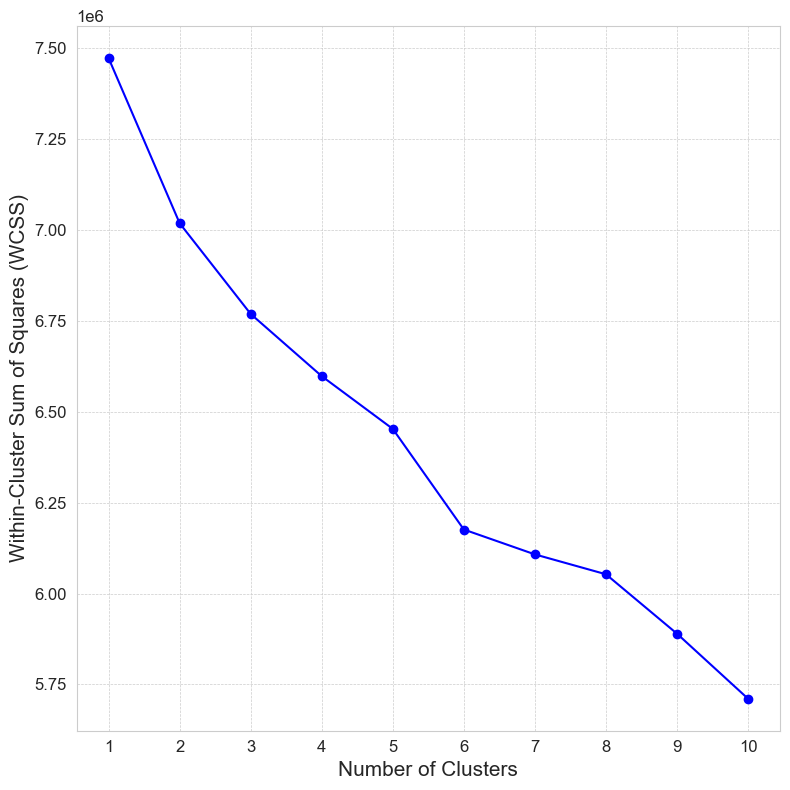

In [211]:
# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11): # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a professional-looking plot
plt.figure(figsize=(8, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='blue')
#plt.title('Elbow Method for Optimal Number of Clusters', fontsize=18, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=15)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/transaction_clustering/kmeans_elbow_method_plot.pdf', format='pdf', dpi=300)

In [3]:
# Apply KMeans clustering
kclusts = 5
kmeans = KMeans(n_clusters=kclusts, init='k-means++', max_iter=300, n_init=10, random_state=1)
kmeans.fit(X_scaled)

# Create a Series for cluster labels with the same index as data_trans_encoded
cluster_labels = pd.Series(kmeans.labels_, index=data_trans_encoded.index)

# Merge the cluster labels into the original DataFrame
trans_df = trans_df.merge(cluster_labels.rename('TransKmeansCluster'), left_index=True, right_index=True, how='left')


In [213]:
trans_df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Site Lat,Site Long,Fuel Type,Actual Fuel Price,Actual Fuel Price Inland,Estimated Price Per Litre,Days Between Transactions,Month Name,Weekday Name,TransKmeansCluster
0,2021-04-04,GGA001EC,TOTAL SAVOY MTHATHA,FUEL,44.89,713.00,FORD,RANGER,FORD RANGER,UMTATA,...,-31.59405,28.756873,DIESEL,13.5212,14.1242,15.883270,NaN,April,Sunday,1.0
1,2021-04-06,GGA001EC,NTLALI MOTORS,FUEL,63.80,1029.14,FORD,RANGER,FORD RANGER,UMTATA,...,-31.59405,28.756873,DIESEL,13.5212,14.1242,16.130721,2.0,April,Tuesday,1.0
2,2021-04-07,GGA001EC,NTLALI MOTORS,FUEL,53.90,901.66,FORD,RANGER,FORD RANGER,UMTATA,...,-31.59405,28.756873,DIESEL,14.1612,14.7762,16.728386,1.0,April,Wednesday,1.0
3,2021-04-08,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,48.12,781.50,FORD,RANGER,FORD RANGER,UMTATA,...,-31.59405,28.756873,DIESEL,14.1612,14.7762,16.240648,1.0,April,Thursday,1.0
4,2021-04-16,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,54.46,884.56,FORD,RANGER,FORD RANGER,UMTATA,...,-31.59405,28.756873,DIESEL,14.1612,14.7762,16.242380,8.0,April,Friday,1.0


## Agglomerative Clustering

In [249]:
from scipy.spatial.distance import pdist
# Sample a subset of the data for clustering
# np.random.seed(0)  # For reproducibility
# sample_indices = np.random.choice(X_scaled.shape[0], size=20000, replace=False)  # Adjust size as needed
# X_sampled = X_scaled[sample_indices]

# Compute the condensed Euclidean distance matrix
distance_matrix = pdist(X_scaled, metric='euclidean')

# Perform hierarchical clustering using the Ward method
Z = linkage(distance_matrix, metric='ward')

In [216]:
from scipy.cluster.hierarchy import fcluster

# Determine the number of clusters based on the cutoff height
clusters = fcluster(Z, t=62, criterion='distance')

# Check the number of clusters
np.unique(clusters)

array([1, 2, 3], dtype=int32)

In [217]:

# The missing link: Track back the sampled indices to the original DataFrame
# Retrieve the original indices from data_trans_encoded that correspond to the sampled rows
original_indices = data_trans_encoded.iloc[sample_indices].index

# Prepare a DataFrame/Series with the original indices and corresponding cluster labels
cluster_labels_df = pd.DataFrame({'AggClusterLabels': clusters}, index=original_indices)

# Merge this DataFrame into the original trans_df DataFrame based on the index
# Since cluster_labels_df is indexed by the original indices, we can directly use join for alignment
trans_df = trans_df.join(cluster_labels_df, how='left')

# BIRCH Clustering

Silhouette Score for 2 clusters: 0.9044
Silhouette Score for 3 clusters: 0.1461
Silhouette Score for 4 clusters: 0.1490
Silhouette Score for 5 clusters: 0.1422
Silhouette Score for 6 clusters: 0.1481
Silhouette Score for 7 clusters: 0.1531
Silhouette Score for 8 clusters: 0.1603
Silhouette Score for 9 clusters: 0.1668
Silhouette Score for 10 clusters: 0.1707


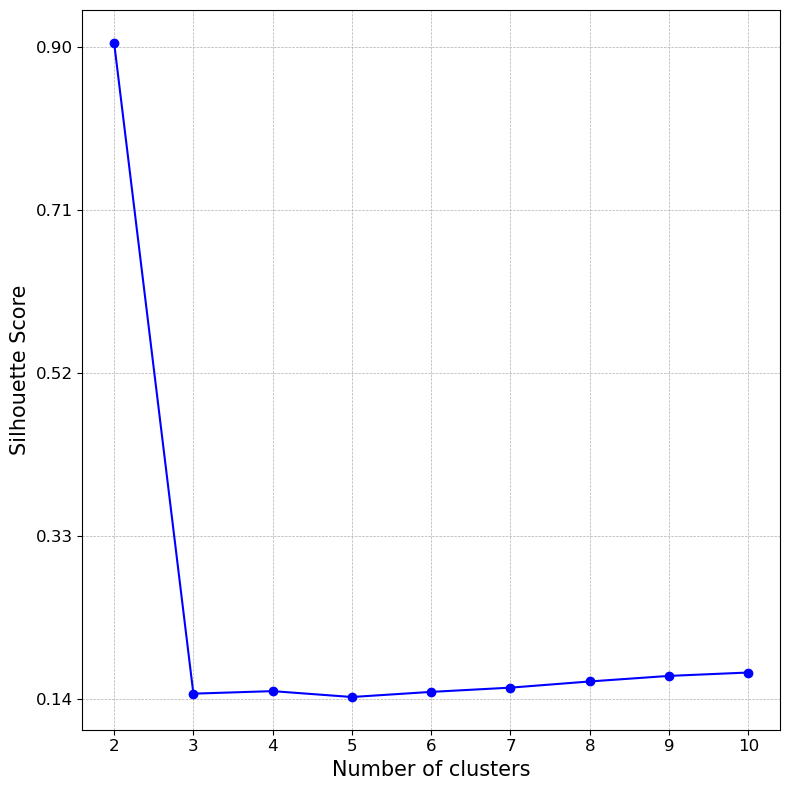

In [5]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

range_n_clusters = list(range(2, 11))  # Example: evaluating from 2 to 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

# Plotting silhouette scores with a more professional aesthetic
plt.figure(figsize=(8, 8))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Silhouette Score', fontsize=15)
plt.xticks(range_n_clusters, fontsize=12)
plt.yticks(np.round(np.linspace(min(silhouette_scores), max(silhouette_scores), 5), 2), fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/transaction_clustering/silhouette_scores_birch.pdf', format='pdf', dpi=150)

plt.show()


In [4]:
from sklearn.cluster import Birch
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_scaled is your scaled dataset
# Adjust the threshold and branching factor according to your dataset size and desired cluster granularity
brc = Birch(n_clusters=3)
brc.fit(X_scaled)


Birch()

In [5]:
labels = brc.labels_

# Create a Series for cluster labels with the same index as data_trans_encoded
cluster_labels = pd.Series(labels, index=data_trans_encoded.index)

# Merge the cluster labels into the original DataFrame
trans_df = trans_df.merge(cluster_labels.rename('TransBirchCluster'), left_index=True, right_index=True, how='left')


In [ ]:

# Plotting the cluster distribution
plt.figure(figsize=(8, 8))
# Assuming we have a 2D dataset for visualization: X_scaled[:, 0], X_scaled[:, 1]
# Adjust according to your dataset dimensions or desired visualization
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1', fontsize=15)
plt.ylabel('Feature 2', fontsize=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.title('BIRCH Clustering', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/transaction_clustering/birch_clustering.pdf', format='pdf', dpi=150)

plt.show()

# Analyzing cluster distribution
unique_clusters = np.unique(labels)
print(f"Number of clusters: {len(unique_clusters)}")


# Gaussian Mixture Model

In [6]:
from sklearn.mixture import GaussianMixture

# If X_processed is a sparse matrix, convert it to a dense matrix
if isinstance(X_scaled, np.ndarray):
    X_dense = X_scaled
else:
    X_dense = X_scaled.toarray()

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=kclusts, random_state=1)
gmm_labels = gmm.fit_predict(X_dense)

# Create a Series for cluster labels with the same index as data_trans_encoded
gmm_labels = pd.Series(gmm_labels, index=data_trans_encoded.index)

# Merge the cluster labels into the original DataFrame
trans_df = trans_df.merge(gmm_labels.rename('TransGMMCluster'), left_index=True, right_index=True, how='left')

In [20]:
trans_df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Fuel Type,Actual Fuel Price,Actual Fuel Price Inland,Estimated Price Per Litre,Days Between Transactions,Month Name,Weekday Name,TransKmeansCluster,TransBirchCluster,TransGMMCluster
0,2021-04-04,GGA001EC,TOTAL SAVOY MTHATHA,FUEL,44.89,713.00,FORD,RANGER,FORD RANGER,UMTATA,...,DIESEL,13.5212,14.1242,15.883270,NaN,April,Sunday,1.0,0.0,4.0
1,2021-04-06,GGA001EC,NTLALI MOTORS,FUEL,63.80,1029.14,FORD,RANGER,FORD RANGER,UMTATA,...,DIESEL,13.5212,14.1242,16.130721,2.0,April,Tuesday,1.0,0.0,4.0
2,2021-04-07,GGA001EC,NTLALI MOTORS,FUEL,53.90,901.66,FORD,RANGER,FORD RANGER,UMTATA,...,DIESEL,14.1612,14.7762,16.728386,1.0,April,Wednesday,1.0,0.0,4.0
3,2021-04-08,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,48.12,781.50,FORD,RANGER,FORD RANGER,UMTATA,...,DIESEL,14.1612,14.7762,16.240648,1.0,April,Thursday,1.0,0.0,4.0
4,2021-04-16,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,54.46,884.56,FORD,RANGER,FORD RANGER,UMTATA,...,DIESEL,14.1612,14.7762,16.242380,8.0,April,Friday,1.0,0.0,4.0


# DBSCAN Clustering

In [21]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Assuming data_processed is your scaled and encoded dataset
neigh = NearestNeighbors(n_neighbors=50)  # Use min_samples value
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

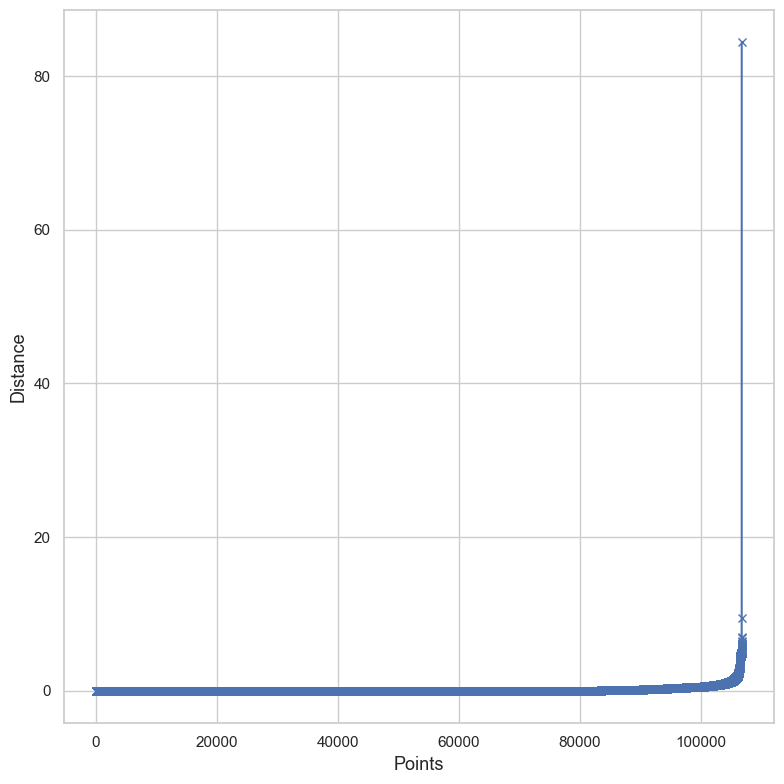

In [23]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")

# Plotting the k-distance graph
plt.plot(distances, 'bx-')  # 'bx-' is a blue color, with 'x' markers and '-' line style
plt.xlabel('Points', fontsize=13)
plt.ylabel('Distance', fontsize=13)
#plt.title('K-Distance Graph', fontsize=14)

plt.tight_layout()
plt.savefig('../final_plots/transaction_clustering/dbscan_kdist_tuning.pdf', format='pdf', dpi=300)
plt.show()

In [20]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
dbscan = DBSCAN(eps=6, min_samples=1500)  # Adjust these parameters as needed
dbscan_clusters = dbscan.fit_predict(X_scaled)

dbscan_labels = dbscan_clusters

# Create a Series for cluster labels with the same index as data_trans_encoded
dbscan_labels = pd.Series(dbscan_labels, index=data_trans_encoded.index)

if 'TransDBSCANCluster' in trans_df.columns:
    trans_df.drop('TransDBSCANCluster', axis=1, inplace=True)

# Merge the cluster labels into the original DataFrame
trans_df = trans_df.merge(dbscan_labels.rename('TransDBSCANCluster'), left_index=True, right_index=True, how='left')

# check the number of clusters
np.unique(dbscan_labels)

array([-1,  0,  1,  2])

In [21]:
dbscan_labels.value_counts()

 0    64850
-1    33034
 2     5386
 1     3466
Name: count, dtype: int64

In [22]:
trans_df.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Actual Fuel Price,Actual Fuel Price Inland,Estimated Price Per Litre,Days Between Transactions,Month Name,Weekday Name,TransKmeansCluster,TransBirchCluster,TransGMMCluster,TransDBSCANCluster
0,2021-04-04,GGA001EC,TOTAL SAVOY MTHATHA,FUEL,44.89,713.00,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,15.883270,NaN,April,Sunday,1.0,0.0,4.0,0.0
1,2021-04-06,GGA001EC,NTLALI MOTORS,FUEL,63.80,1029.14,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,16.130721,2.0,April,Tuesday,1.0,0.0,4.0,0.0
2,2021-04-07,GGA001EC,NTLALI MOTORS,FUEL,53.90,901.66,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.728386,1.0,April,Wednesday,1.0,0.0,4.0,0.0
3,2021-04-08,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,48.12,781.50,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.240648,1.0,April,Thursday,1.0,0.0,4.0,0.0
4,2021-04-16,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,54.46,884.56,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.242380,8.0,April,Friday,1.0,0.0,4.0,0.0


In [23]:
# Save the transaction clusters to a CSV file
trans_df.to_csv('../data/final_transactions_with_clusters.csv', index=False)

# Plotting the transaction plots

In [82]:
import pandas as pd

# Read the final transaction dataset
final_transactions = pd.read_csv('../data/final_transactions_with_clusters.csv')

# Display the first few rows of the dataset
final_transactions.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Actual Fuel Price,Actual Fuel Price Inland,Estimated Price Per Litre,Days Between Transactions,Month Name,Weekday Name,TransKmeansCluster,TransBirchCluster,TransGMMCluster,TransDBSCANCluster
0,2021-04-04,GGA001EC,TOTAL SAVOY MTHATHA,FUEL,44.89,713.00,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,15.883270,NaN,April,Sunday,1.0,0.0,4.0,0.0
1,2021-04-06,GGA001EC,NTLALI MOTORS,FUEL,63.80,1029.14,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,16.130721,2.0,April,Tuesday,1.0,0.0,4.0,0.0
2,2021-04-07,GGA001EC,NTLALI MOTORS,FUEL,53.90,901.66,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.728386,1.0,April,Wednesday,1.0,0.0,4.0,0.0
3,2021-04-08,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,48.12,781.50,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.240648,1.0,April,Thursday,1.0,0.0,4.0,0.0
4,2021-04-16,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,54.46,884.56,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.242380,8.0,April,Friday,1.0,0.0,4.0,0.0


In [83]:
# Rename the cluster columns for better readability
final_transactions.rename(columns={
    'TransKmeansCluster': 'KMeans Cluster',
    'TransBirchCluster': 'Birch Cluster',
    'TransGMMCluster': 'GMM Cluster',
    'TransDBSCANCluster': 'DBSCAN Cluster'
}, inplace=True)

# Drop the NaN values in the cluster columns
final_transactions.dropna(subset=['KMeans Cluster', 'Birch Cluster', 'GMM Cluster', 'DBSCAN Cluster'], inplace=True)

# List of cluster columns to adjust
cluster_columns = ['KMeans Cluster', 'Birch Cluster', 'GMM Cluster', 'DBSCAN Cluster']

# Adjust each cluster column
for column in cluster_columns:
    # Increment cluster number by 1
    if min(final_transactions[column]) <= 0.0:
        final_transactions[column] = final_transactions[column] + 1
    # Convert to string and prepend with "Cluster "
    final_transactions[column] = 'Cluster ' + final_transactions[column].astype(str)

    # Now, use regex to remove any trailing '.0' from the string representation
    final_transactions[column] = final_transactions[column].replace(to_replace=r'\.0$', value='', regex=True)


# Display the first few rows to verify the changes
final_transactions.head()

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Actual Fuel Price,Actual Fuel Price Inland,Estimated Price Per Litre,Days Between Transactions,Month Name,Weekday Name,KMeans Cluster,Birch Cluster,GMM Cluster,DBSCAN Cluster
0,2021-04-04,GGA001EC,TOTAL SAVOY MTHATHA,FUEL,44.89,713.00,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,15.883270,NaN,April,Sunday,Cluster 2,Cluster 1,Cluster 5,Cluster 1
1,2021-04-06,GGA001EC,NTLALI MOTORS,FUEL,63.80,1029.14,FORD,RANGER,FORD RANGER,UMTATA,...,13.5212,14.1242,16.130721,2.0,April,Tuesday,Cluster 2,Cluster 1,Cluster 5,Cluster 1
2,2021-04-07,GGA001EC,NTLALI MOTORS,FUEL,53.90,901.66,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.728386,1.0,April,Wednesday,Cluster 2,Cluster 1,Cluster 5,Cluster 1
3,2021-04-08,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,48.12,781.50,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.240648,1.0,April,Thursday,Cluster 2,Cluster 1,Cluster 5,Cluster 1
4,2021-04-16,GGA001EC,ELLIOTDALE FILLING STATION,FUEL,54.46,884.56,FORD,RANGER,FORD RANGER,UMTATA,...,14.1612,14.7762,16.242380,8.0,April,Friday,Cluster 2,Cluster 1,Cluster 5,Cluster 1


In [28]:
final_transactions.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre', 'Days Between Transactions', 'Month Name',
       'Weekday Name', 'KMeans Cluster', 'Birch Cluster', 'GMM Cluster',
       'DBSCAN Cluster'],
      dtype='object')

In [84]:
plot_bivariate_grid(final_transactions, 'Transaction Amount', cluster_columns, 
                    '../final_plots/transaction_clustering/TransAmount_vs_Clusters_boxplots.pdf')

plot_bivariate_grid(final_transactions, 'No. of Litres', cluster_columns, 
                    '../final_plots/transaction_clustering/SumLitres_vs_Clusters_boxplots.pdf')

In [85]:
plot_categorical_distributions(final_transactions, 'District', cluster_columns, 
                    '../final_plots/transaction_clustering/District_vs_Clusters_boxplots.pdf')

plot_categorical_distributions(final_transactions, 'Model', cluster_columns, 
                    '../final_plots/transaction_clustering/MakeModel_vs_Clusters_boxplots.pdf')

# plot_categorical_distributions(final_transactions, 'Category', cluster_columns, 
#                     '../final_plots/transaction_clustering/Category_vs_Clusters_boxplots.pdf')